Pour ce sujet, je me suis aidé de du tutoriel de tensorflow : https://www.tensorflow.org/tutorials/images/classification?hl=fr

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Explorez le jeu de données

In [ ]:
import pathlib
data_dir = pathlib.Path("./Dataset")

In [ ]:
image_count = len(list(data_dir.glob('*/*.BMP')))
print(image_count)

216


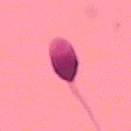

In [ ]:
normal = list(data_dir.glob('normal/*'))
PIL.Image.open(str(normal[0]))

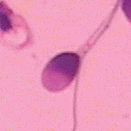

In [ ]:
PIL.Image.open(str(normal[1]))

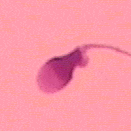

In [ ]:
pyriform = list(data_dir.glob('pyriform/*'))
PIL.Image.open(str(pyriform[0]))

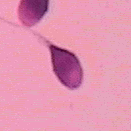

In [ ]:
PIL.Image.open(str(pyriform[1]))

## Créer un ensemble de données

In [ ]:
image_count = len(list(data_dir.glob('*/*.BMP')))
print(image_count)

216


In [ ]:
batch_size = 5
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 216 files belonging to 4 classes.
Using 173 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 216 files belonging to 4 classes.
Using 43 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['amorphous', 'normal', 'pyriform', 'tapered']


## Visualisez les données

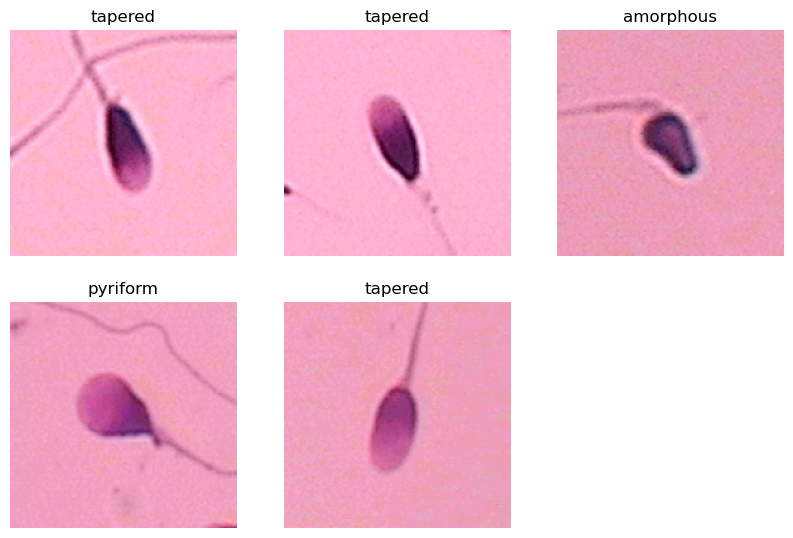

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(min(9, len(images))): 
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      plt.axis("off")

plt.show()

In [ ]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(5, 180, 180, 3)
(5,)


## Configurer l'ensemble de données pour les performances

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardiser les données

In [ ]:
normalization_layer = layers.Rescaling(1./255)

## Créer le modèle

In [ ]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

## Compiler le modèle

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Résumé du modèle

In [ ]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_25 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_51 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_51 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_52 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_52 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_53 (Conv2D)          (None, 45, 45, 64)      

## Former le modèle

In [ ]:
epochs=20
# history = model.fit(
#   train_ds,
#   validation_data=val_ds,
#   epochs=epochs
# )

## Visualisez les résultats de l'entraînement

In [ ]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs_range = range(epochs)

# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

## Augmentation des données

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

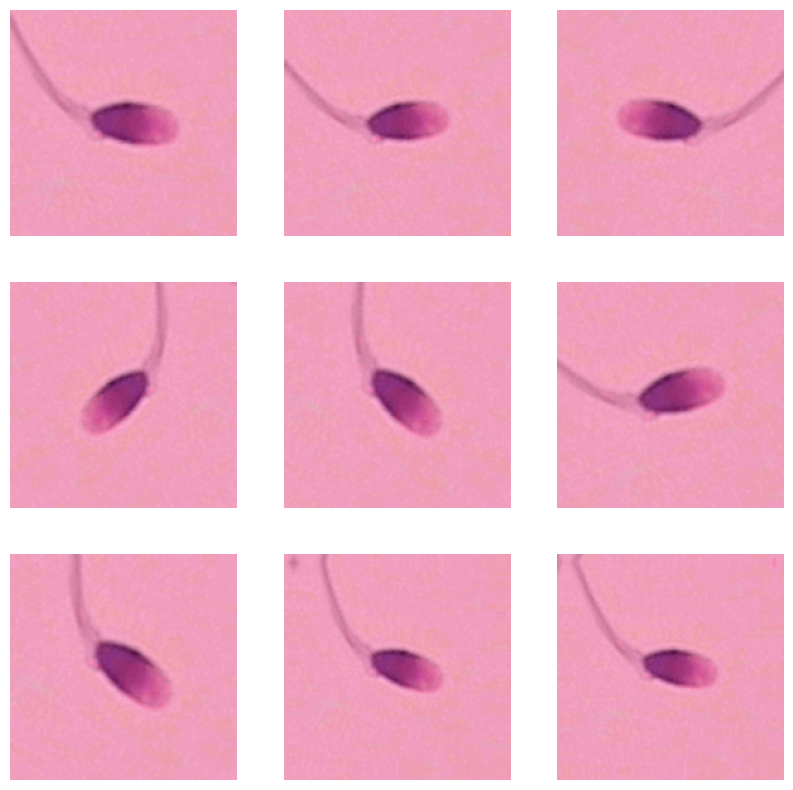

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Régularisation des abandons dans le réseau

In [ ]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

## Compiler et entraîner le modèle

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_21 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_26 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_54 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_54 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_55 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_55 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                               

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

## Visualisez les résultats de l'entraînement

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# model.save_weights('./models/model_1_15_epochs/')

In [ ]:
img_height

180

In [ ]:
img_width

180

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
from PIL import Image
import numpy as np
from skimage import transform

In [ ]:
# model = Sequential([
#     data_augmentation,
#     layers.Rescaling(1./255),
#     layers.Conv2D(16, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Conv2D(32, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Conv2D(64, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Dropout(0.2),
#     layers.Flatten(),
#     layers.Dense(128, activation='relu'),
#     layers.Dense(num_classes)
# ])

In [ ]:
def load(filename):
    np_image = Image.open(filename)
    np_image = np.array(np_image).astype('float32')/255
    np_image = transform.resize(np_image, (180, 180, 3))
    np_image = np.expand_dims(np_image, axis=0)
    return np_image


In [ ]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])



['amorphous', 'normal', 'pyriform', 'tapered']

In [ ]:

image = load('./Dataset/normal/image_004.BMP')
model.predict(image)

1/1 [==============================] - 0s 62ms/step


array([[ 0.00036448, -0.00021805, -0.00027896,  0.00034014]],
      dtype=float32)

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array


model.load_weights('./models/model_1_15_epochs/')

image_path = './Dataset/pyriform/image_005.BMP'
image = load_img(image_path, target_size=(180, 180, 3)) 
image_array = img_to_array(image)
image_array = image_array[np.newaxis, ...]

prediction = model.predict(image_array)
print(prediction)

1/1 [==============================] - 0s 19ms/step
[[-1.599593   -0.35195312  0.61654884  0.37173882]]


In [ ]:
probs = np.exp(prediction) / np.sum(np.exp(prediction), axis=1, keepdims=True)

predicted_class = np.argmax(probs, axis=1)

print("Probabilités par classe:", probs)
print("Classe prédite:", predicted_class)

Probabilités par classe: [[0.04799795 0.16713439 0.44023123 0.34463644]]
Classe prédite: [2]


In [ ]:
class_names = ['amorphous', 'normal', 'pyriform', 'tapered']

probs = np.exp(prediction) / np.sum(np.exp(prediction), axis=1, keepdims=True)

predicted_class = np.argmax(probs, axis=1)

predicted_class_name = class_names[predicted_class[0]]
print("Probabilités par classe:", probs)
print("Classe prédite:", predicted_class_name)

Probabilités par classe: [[0.04799795 0.16713439 0.44023123 0.34463644]]
Classe prédite: pyriform
